In [1]:
import glob
import numpy as np
import pandas as pd
import os
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [2]:
sorted(glob.glob('data/raw/*_*_0[1-4]*'))

['data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
 'data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅',
 'data/raw/01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_01_04_4F実験室_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
 'data/raw/01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出',
 'data/raw/01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出',
 'data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅',
 'data/raw/01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅',
 'data/raw/01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅',
 'data/raw/01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
 'data/raw/01_11_02_エネマネハウス_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅',
 'data/raw/01_11_03_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_11_04_エネマネハウス_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_12_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
 'data/raw/01_12_02_エネマネハウス_XperiaZ3_ズボン_裏上_異常_まっすぐ外出',
 'data/raw/01_12_03_エネマネハウス_XperiaZ3_カバン_裏上_異常_まっすぐ外出',
 'data/raw/01_13_01_エネマネハウス_XperiaZ3_胸ポケット

In [3]:
def _get_dir_list(path):
    return glob.glob(path)

def _get_file_list_in_dir(d):
    f = glob.glob(d + '/*.csv')
    f.sort()
    return f

def _get_df_from_csv(f):
    is_iOS = "iphone" in f
    df = pd.read_csv(f)

    if is_iOS:
        # rename column name to integrate
        df.rename(columns={'rssi': 'remote_rssi'}, inplace=True)
        # remove unsaved parameters
        del df['magneticField.accuracy']
        del df['magneticField.field.x']
        del df['magneticField.field.y']
        del df['magneticField.field.z']
    else:
        # rename column name to integrate
        df.rename(columns={'rssi(A)': 'rssi.a'}, inplace=True)
        df.rename(columns={'rssi(B)': 'rssi.b'}, inplace=True)
        # remove unsaved parameters
        del df['temperature']
        del df['humidity']
        del df['proximity']

    # remove data while rssi is not recorded
    buf = np.where(df['rssi.a'].as_matrix() != -1)[0]
    if len(buf) == 0:
        print('x', end='')
        return None
    
    first_rssi_idx = buf[0]
    df = df.ix[first_rssi_idx:, :]

    # type specify
    for c in df.columns[1:]:
        df[c] = df[c].astype(float)

    # adjust the value of button pushed data 
    df.loc[df['btn_push'] == -1, 'btn_push'] = 0

    # convert -1 to NaN
    df[df == -1] = np.nan

    print('.', end='')

    return df

def load(path='data/raw/*_*_0[1-4]*'):
    """
    load csv data from the specified path
    """
    print("path = " + path)
    d = _get_dir_list(path)
    title = [os.path.basename(_d) for _d in d]

    r = []
    for _d in d:
        print(_d)
        title = os.path.basename(_d)
        file_list = _get_file_list_in_dir(_d)
        fname_list = [os.path.basename(_f) for _f in file_list]
        df_list = [_get_df_from_csv(f) for f in file_list]
        print('')
        r.extend([[title, fn, df] for (fn, df) in zip(fname_list, df_list)])

    ds = pd.DataFrame(r, columns=('title', 'fname', 'dataframe'))
    return ds

In [95]:
def _time_range_around_button_push(df, before=0, after=0):
    t = df[df['btn_push'] == 1].index
    point = t[0] if len(t) > 0 else df.index[-1] - 250
    return df.loc[(point - before):(point + after)]

def get_data(ds, title='.*', fname='.*', before=None, after=0, column=None, drop_interval=1):
    """
    return copied list of dataframe, limited by column and frame number.
    """
    # extract the [title, fname, dataframe]
    dfm = ds[ds['title'].str.contains(title)]
    dfm = dfm[dfm['fname'].str.contains(fname)]
    column = list_flatten(column)
    
    print(dfm['title'].unique())
    
    # to list of dataframe
    dfl = [d for d in dfm['dataframe'].tolist() if d is not None]
    # copy dataframe
    dfl = [df.copy() for df in dfl]
    # NaN fill as foward data
    dfl = [df.fillna(method='ffill') for df in dfl]
    # limit the time range
    dfl = [_time_range_around_button_push(d, before*drop_interval, after*drop_interval) for d in dfl]
    # drop interval
    dfl = [df[::drop_interval] for df in dfl]
    # limit the column
    if column != None: dfl = [d[column] for d in dfl]
    print("extracted %d dataframes" % (len(dfl)))
    return dfl

In [93]:
def _get_mean_std_3d(dfl, x, y, z):
    merged_df = pd.concat([df for df in dfl])
    x = merged_df[x]
    y = merged_df[y]
    z = merged_df[z]
    std = (x*x + y*y + z*z).apply(lambda x: math.sqrt(x)).std()
    x_mean = x.mean()
    y_mean = y.mean()
    z_mean = z.mean()
    return (x_mean, y_mean, z_mean, std)

def _get_mean_std_1d(dfl, x):
    merged_df = pd.concat([df for df in dfl])
    x = merged_df[x]
    std = x.std()
    mean = x.mean()
    return (mean, std)

def _get_mean_std(dfl, column):
    mean = []
    std = []
    for c in column:
        if type(c) == list:
            (mx, my, mz, _s) = _get_mean_std_3d(dfl, c[0], c[1], c[2])
            mean.extend([mx, my, mz])
            std.extend([_s]*3)
        else:
            (_mean, _s) = _get_mean_std_1d(dfl, c)
            mean.append(_mean)
            std.append(_s)
    return (mean, std)

def list_flatten(l):
    _l = []
    for l in l:
        if type(l) == list: _l.extend(l)
        else:               _l.append(l)
    return _l

def normalize(dfl, mean_std, column):
    dfl_new = []
    for df in dfl:
        df_new = pd.DataFrame()
        for (m, s, c) in zip(mean_std[0], mean_std[1], column):
            df_new[c] = (df[c] - m)/s
        dfl_new.append(df_new)
    return dfl_new

def normalize_by_base_data(dfl_base, dfl_target, column):
    ms = _get_mean_std(dfl_base, column)
    return normalize(dfl_target, ms, list_flatten(column))

In [63]:
def sample2():
    ds = load('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
    dfl = get_data(ds, before=6, after=0, column=['rssi.b','rssi.a','linear_accel[0]','linear_accel[1]','linear_accel[2]','btn_push'], drop_interval=3)
    return dfl[0]
#sample2()

path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
path = data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
...
['01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅']
extracted 3 dataframes
['01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出']
extracted 3 dataframes


,rssi.a,linear_accel[0],linear_accel[1],linear_accel[2]
643,-26.0,-0.115767,0.002029,0.526729
644,-25.0,0.120929,0.029972,0.608754
645,-25.0,-0.242042,0.052567,0.493274
646,-25.0,-0.491172,0.254213,0.432572
647,-25.0,-0.700672,0.334507,0.613842
648,-24.0,-0.369455,0.505239,0.427036
649,-24.0,-0.463415,0.443812,0.667643


,rssi.a,linear_accel[0],linear_accel[1],linear_accel[2]
643,-2.629503,0.008026,-0.749022,1.444473
644,-0.956183,1.025201,-0.628941,1.796969
645,-0.956183,-0.534623,-0.531844,1.300704
646,-0.956183,-1.605230,0.334709,1.039844
647,-0.956183,-2.505532,0.679761,1.818830
648,0.717137,-1.082167,1.413459,1.016054
649,0.717137,-1.485950,1.149488,2.050033


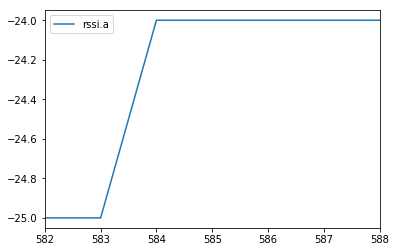

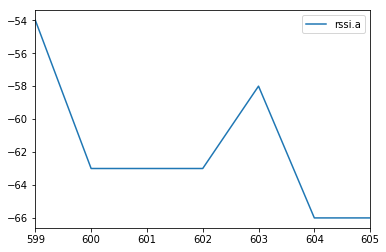

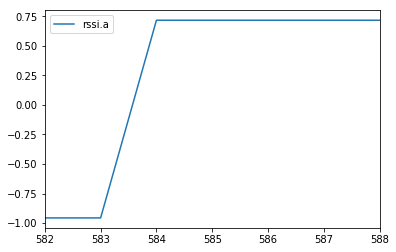

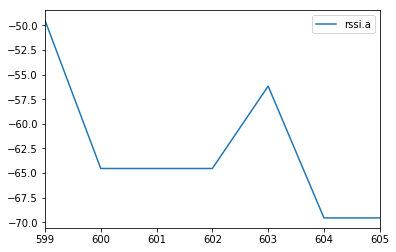

In [94]:
def sample3():
    # load dataset
    ds_nml = load('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
    ds_out = load('data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出')

    # set column
    column = ['rssi.a',['linear_accel[0]','linear_accel[1]','linear_accel[2]']]

    # get around button pushed time
    dfl_n = get_data(ds_nml, before=6, after=0, column=list_flatten(column))
    dfl_o = get_data(ds_out, before=6, after=0, column=list_flatten(column))
    
    display(dfl_n[0])

    # normalize
    dfl_n_norm = normalize_by_base_data(dfl_n, dfl_n, column)
    dfl_o_norm = normalize_by_base_data(dfl_n, dfl_o, column)

    display(dfl_n_norm[0])
    
    # plot graph
    dfl_n[1][[0]].plot()
    dfl_o[1][[0]].plot()
    dfl_n_norm[1][[0]].plot()
    dfl_o_norm[1][[0]].plot()

#sample3()

In [20]:
def sample1():
    ds = load('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
    ds.iloc[0]['dataframe'].info()
    return ds.info()
#sample1()

path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 175 to 746
Data columns (total 31 columns):
date                572 non-null object
rssi.a              281 non-null float64
rssi.b              285 non-null float64
remote_rssi         567 non-null float64
linear_accel[0]     568 non-null float64
linear_accel[1]     568 non-null float64
linear_accel[2]     568 non-null float64
accelerometer[0]    568 non-null float64
accelerometer[1]    568 non-null float64
accelerometer[2]    568 non-null float64
gravity[0]          566 non-null float64
gravity[1]          566 non-null float64
gravity[2]          566 non-null float64
gyro[0]             567 non-null float64
gyro[1]             567 non-null float64
gyro[2]             567 non-null float64
rotation[0]         565 non-null float64
rotation[1]         565 non-null float64
rotation[2]         565 non-null float64
